# Reccurrent Neural Networks for Temporal Analysis of Accidents

In [1]:
#At first, import required library
import pandas as pd

## Data Preparation Tools 

### Function to access and understand the data

In [2]:
#Create a function to read data. The user need to enter the name of the columns where required data can be found
def read_data():
    file_name = input('Please type the name of csv file with accident data: ')
    day_input = input('Please type the column names of day: ')
    month_input = input('Please type the column names of month: ')
    year_input = input('Please type the column names of year: ')
    longitude_input = input('Please type the column names of longitude: ')
    latitude_input = input('Please type the column names of latitude : ')
    data = pd.read_csv(file_name, usecols = [day_input, month_input, year_input, longitude_input, latitude_input])
    data = pd.DataFrame(data)
    #print(data)
    return data

### Function to concat year, month and day of different columns into single column

In [13]:
#Create a function to join columns with year, month and day
def add_date(file):
    data = file
    day = data['Day']
    month = data['Month']
    year = data['Year']
    file['Date'] = '20'+year.map(str) + '-' + month.map(str) + '-' + day.map(str)
    file['Date'] = pd.to_datetime(file['Date'])
    file = file.sort_values(by="Date")
    return file

### Function to export the prepared data into a csv file 

In [14]:
#Define a function to add a count column and export to csv
def export_to_csv(file):
    data = file
    data['Count'] = 1
    data = data[['Date', 'Count']].groupby(['Date']).sum()
    data.to_csv('testacci.csv')

In [11]:
#euska_export_Bremen_.csv

In [7]:
#Now call the read_data() function
file = read_data()

Please type the name of csv file with accident data: euska_export_Bremen_.csv
Please type the column names of day: Day
Please type the column names of month: Month
Please type the column names of year: Year
Please type the column names of longitude: Longitude
Please type the column names of latitude : Latitude


In [15]:
#Concat the datetime into single column
add_date(file)

,Day,Month,Year,Longitude,Latitude,Date
20256,1,1,15,8.798485,53.063440,2015-01-01
12327,1,1,15,8.810380,53.082009,2015-01-01
339,1,1,15,8.807961,53.088592,2015-01-01
33098,1,1,15,8.940964,53.058464,2015-01-01
33193,1,1,15,8.873780,53.101185,2015-01-01
...,...,...,...,...,...,...
16800,31,12,18,8.949970,53.063029,2018-12-31
6755,31,12,18,8.640433,53.189146,2018-12-31
13210,31,12,18,8.872339,53.107905,2018-12-31
4268,31,12,18,8.795121,53.074058,2018-12-31


In [16]:
export_to_csv(file)

## Modeling Tools 

In [17]:
#DailyAccidents_Jan_15_Mar_18.csv
#DailyAccidents_Apr_18_Dec_18.csv

In [19]:
train_file = input('Please enter the name of training file with extension: ')

Please enter the name of training file with extension: DailyAccidents_Jan_15_Mar_18.csv


In [20]:
test_file = input('Please enter the name of testing file with extension: ')

Please enter the name of testing file with extension: DailyAccidents_Apr_18_Dec_18.csv


In [21]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
#Import and define variable for Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

### Data Preprocessing Tools 

In [24]:
#Define a function to prepare the training data
def train_data(train_file):
    dataset_train = pd.read_csv(train_file)
    training_set = dataset_train.iloc[:,1:2].values
    #Feature Scaling
    #from sklearn.preprocessing import MinMaxScaler
    #sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    
    #Creating a data structure with 60 timesteps and 1 output
    X_train = []
    y_train = []
    timestamp = int(input('Please enter the timestamp: '))
    #train_data_size = int(input('Please enter the timestamp'))
    for i in range(timestamp, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-timestamp:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    #Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #1 is predictor/indicator here
    return X_train, y_train, dataset_train, timestamp

### Model building tools 

In [25]:
#Step 2: Build the network
def build_network():
    print('loading  required libraries ...')
    #Importing the keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    print('... done with loading libraries')
    
    #Inputs for variables and hyperparameters.
    units = int(input('Please enter the number of units: '))#50
    optimizer = input('Please enter the name of the optimizer of your choice: ')#adam
    loss = input('Please enter the name of loss you want to compute: ')#mean_squared_error
    epochs = int(input('Please enter the number of epochs: '))#100
    batch_size = int(input('Please enter the batch size: '))#15
    
    #Build the model
    #Initialising the RNN
    regressor = Sequential()

    #Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    #Adding the second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = units, return_sequences = True))
    regressor.add(Dropout(0.2))

    #Adding the third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = units, return_sequences = True))
    regressor.add(Dropout(0.2))

    #Adding the fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = units))
    regressor.add(Dropout(0.2))

    #Adding the output layer
    regressor.add(Dense(units = 1))

    #Compiling the RNN, adam, mean_squared_error
    regressor.compile(optimizer = optimizer, loss = loss)

    #Fitting the RNN to the Training set 100, 5
    regressor.fit(X_train, y_train, epochs = epochs, batch_size= batch_size)
    return regressor

### Testing and Prediction Tools 

In [26]:
def make_prediction(test_data):
    #Getting the real accidents from Apr 2018
    dataset_test = pd.read_csv(test_data)
    real_accident_number = dataset_test.iloc[:, 1:2].values

    #Getting the predicted accidents of April 2018
    dataset_total = pd.concat((train[2]['Count'], dataset_test['Count']), axis = 0)
    inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    #Now prepare variable for prediction
    X_test = []
    for i in range(timestamp, (len(dataset_test)+60)):
        X_test.append(inputs[i-timestamp:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_accident_number = regressor.predict(X_test)
    predicted_accident_number = sc.inverse_transform(predicted_accident_number)
    return predicted_accident_number, real_accident_number

### Visualization Tools 

In [33]:
#Define a function to visualize the result
def visualize_result():
    #Visualizing the results
    plt.plot(real_accident_number, color = 'red', label = 'Real Accident Number')
    plt.plot(predicted_accident_number, color = 'blue', label = 'Predicted Accident Number')
    plt.title('Daily Accident Prediction')
    plt.xlabel('Days')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.show()
    plt.savefig('Prediction_of_Accidents.png')

### Model Evaluation Tools 

In [34]:
#Define a function for evaluating the model
def evaluate_model():
    #Compute the RMSE
    import math
    from sklearn.metrics import mean_squared_error
    rmse = math.sqrt(mean_squared_error(real_accident_number, predicted_accident_number))
    
    #Compute Relative Error
    mean_predicted_accident_number = predicted_accident_number.mean()
    relative_error = rmse/mean_predicted_accident_number
    return rmse, mean_predicted_accident_number, relative_error

## Implementation of developed Tools 

In [ ]:
As all the required functions are defined, now lets implement these functions in the section below

In [27]:
train = train_data('DailyAccidents_Jan_15_Mar_18.csv')
X_train = train[0]
y_train = train[1]
dataset_train = train[2]
timestamp = train[3]
X_train, y_train, dataset_train

Please enter the timestamp: 60


(array([[[0.05357143],
         [0.14285714],
         [0.125     ],
         ...,
         [0.5       ],
         [0.39285714],
         [0.125     ]],
 
        [[0.14285714],
         [0.125     ],
         [0.16071429],
         ...,
         [0.39285714],
         [0.125     ],
         [0.48214286]],
 
        [[0.125     ],
         [0.16071429],
         [0.26785714],
         ...,
         [0.125     ],
         [0.48214286],
         [0.46428571]],
 
        ...,
 
        [[0.08928571],
         [0.64285714],
         [0.375     ],
         ...,
         [0.39285714],
         [0.39285714],
         [0.42857143]],
 
        [[0.64285714],
         [0.375     ],
         [0.5       ],
         ...,
         [0.39285714],
         [0.42857143],
         [0.51785714]],
 
        [[0.375     ],
         [0.5       ],
         [0.58928571],
         ...,
         [0.42857143],
         [0.51785714],
         [0.17857143]]]),
 array([0.48214286, 0.46428571, 0.44642857, ..., 0.5178

In [28]:
regressor = build_network()

loading  required libraries ...


Using TensorFlow backend.


... done with loading libraries
Please enter the number of units: 25
Please enter the name of the optimizer of your choice: adam
Please enter the name of loss you want to compute: mean_squared_error
Please enter the number of epochs: 100
Please enter the batch size: 15
Epoch 1/100
1124/1124 [==============================] - 7s 7ms/step - loss: 0.0546
Epoch 2/100
1124/1124 [==============================] - 5s 4ms/step - loss: 0.0364
Epoch 3/100
1124/1124 [==============================] - 5s 4ms/step - loss: 0.0364
Epoch 4/100
1124/1124 [==============================] - 5s 4ms/step - loss: 0.0373
Epoch 5/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0355
Epoch 6/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0359
Epoch 7/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0361
Epoch 8/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0359
Epoch 9/100
1124/1124 [==============================] - 6

1124/1124 [==============================] - 6s 5ms/step - loss: 0.0200
Epoch 95/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0196
Epoch 96/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0194
Epoch 97/100
1124/1124 [==============================] - 7s 7ms/step - loss: 0.0193
Epoch 98/100
1124/1124 [==============================] - 7s 6ms/step - loss: 0.0192
Epoch 99/100
1124/1124 [==============================] - 7s 6ms/step - loss: 0.0185
Epoch 100/100
1124/1124 [==============================] - 6s 5ms/step - loss: 0.0189


In [30]:
train[2]['Count']

0        5
1       10
2        9
3       11
4       17
        ..
1179    24
1180    26
1181    31
1182    12
1183    25
Name: Count, Length: 1184, dtype: int64

In [35]:
accident_number = make_prediction('DailyAccidents_Apr_18_Dec_18.csv')
real_accident_number = accident_number[1]
predicted_accident_number = accident_number[0]

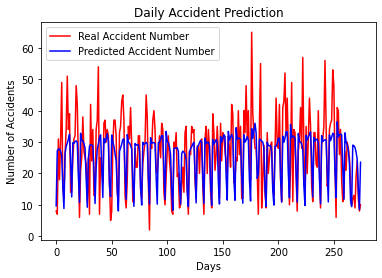

<Figure size 432x288 with 0 Axes>

In [36]:
visualize_result()

In [38]:
evaluation = evaluate_model()
rmse = evaluation[0]
mean_predicted_accident_number = evaluation[1]
relative_error = evaluation[2]

In [39]:
print(rmse, mean_predicted_accident_number, relative_error)
print('Done with accident prediction')

8.636377705698616 25.505512 0.3386082829963427
Done with accident prediction


## Conclusion 